In [ ]:
#!/usr/bin/env python
# coding: utf-8

"""
Learning Rate Range Test: Training process for finding the optimal Learning Rate
"""

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Check if is running on Colab

In [ ]:
use_colab = 'google.colab' in str(get_ipython())

if use_colab:
    # Define base path
    BASE_PATH = '/content/gdrive/My Drive/Colab Notebooks/DESC-NET/src/'

    # Import Libraries from colab
    from google.colab import drive
    from google.colab import output
    import IPython
    
    # Mount Google Drive for fast, responsible access to files
    drive.mount('/content/gdrive')
    
    message_use_colab = '[INFO] Running on Colab:\n'
else:
    message_use_colab = '[INFO] Not running on Colab:\n'
    pass

# Colab Runtime to prevent from disconnecting

In [ ]:
if use_colab:
    display(IPython.display.Javascript('''
    function ClickConnect(){
        btn = document.querySelector("colab-connect-button")
        if (btn != null){
          console.log("Click colab-connect-button"); 
          btn.click() 
        }
        
        btn = document.getElementById('ok')
        if (btn != null){
          console.log("Click reconnect"); 
          btn.click() 
        }
      }
        
    setInterval(ClickConnect, 60000)'''))
else:
    pass

# Import Libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import CustomObjectScope
import json
import numpy as np
import tensorflow as tf
import zipfile
import os

# Remove warnings from keras model
tf.get_logger().setLevel('ERROR')

# Import Custom Libraries

In [ ]:
# To import and use the custom imports, the folder need
# to be in se same directory to de file (in colab) 
if use_colab:
    # Unzip in Colab Workspace
    UTILITIES = 'utilities.zip'

    UTILITIES_PATH =  "/".join([BASE_PATH, UTILITIES])

    zip_object = zipfile.ZipFile(file = UTILITIES_PATH,
                                mode = 'r')

    zip_object.extractall()

    zip_object.close

from utilities.dataset import(#manipulate_pandas,
                              create_dataset
)

from utilities.descriptors import find_detector_or_descriptor

from utilities import global_variables



from utilities.timer import Timer

from utilities.visualizations import(#save_dataset_distribution,
                                     save_architecture_visualization,
                                     save_model_accuracy_history,
                                     save_model_loss_history,
                                     save_confusion_matrix,
)


from utilities.local_descriptor_convolution import * # TODO: Arrumar e importar todos... depois...

from utilities.residual_neural_network import ResNet

from utilities.model_functions import(training,
                                      evaluate,
                                      predict)

# Import config.json
## Used to load the user configurations

In [ ]:
if use_colab:
    # Unzip in Colab Workspace
    JSON = 'config-FEI.zip'

    JSON_PATH =  "/".join([BASE_PATH, JSON])

    zip_object = zipfile.ZipFile(file = JSON_PATH,
                                 mode = 'r')

    zip_object.extractall()

    zip_object.close 

JSON_PATH = 'config.json'

# Load the user configurations
with open(JSON_PATH, encoding='utf8') as f:    
    config = json.load(f)

# Unzip outside Dataset

In [ ]:
# Stores the dataset's name
DATASET = config['dataset']

try:
    assert(DATASET == 'MNIST' or
           DATASET == 'JAFFE' or
           DATASET == 'Extended-CK+' or
           DATASET == 'CIFAR-10' or
           DATASET == 'CIFAR-100' or
           DATASET == 'FEI' or
           DATASET == 'FER-2013' or
           DATASET == 'ILSVRC-2017')
except AssertionError as e:
    raise(AssertionError('`DATASET` cannot be different from MNIST or JAFFE or Extended-CK+ or CIFAR-10 or CIFAR-100 or FEI or FER-2013 or ILSVRC-2017'))

# Path of training-set
DATA_TRAIN_IMAGES = "/".join([config['dataset'], config['data_train_images']])

# Path of test-set
DATA_TEST_IMAGES = "/".join([config['dataset'], config['data_test_images']])

# Stores the detector's name
DETECTOR = config['detector']

try:
    assert(DETECTOR == 'SIFT' or
           DETECTOR == 'SURF' or
           DETECTOR == 'KAZE' or
           DETECTOR == 'ORB' or
           DETECTOR == 'BRISK' or
           DETECTOR == 'AKAZE')
except AssertionError as e:
    raise(AssertionError('`DETECTOR` cannot be different from SIFT or SURF or KAZE or ORB or BRISK or AKAZE'))

# Stores the descriptor's name
DESCRIPTOR = config['descriptor']

try:
    assert(DESCRIPTOR == 'SIFT' or
           DESCRIPTOR == 'SURF' or
           DESCRIPTOR == 'KAZE' or
           DESCRIPTOR == 'BRIEF' or
           DESCRIPTOR == 'ORB' or
           DESCRIPTOR == 'BRISK' or
           DESCRIPTOR == 'AKAZE' or
           DESCRIPTOR == 'FREAK')
except AssertionError as e:
    raise(AssertionError('`DESCRIPTOR` cannot be different from SIFT or SURF or KAZE or BRIEF or ORB or BRISK or AKAZE or FREAK'))

# Stores the reducer's name
#REDUCER = config['reducer']

# Stores the architecture's name of CNN
ARCHITECTURE = config['architecture']

try:
    assert(ARCHITECTURE == 'DescNet-50' or
           ARCHITECTURE == 'DescNet-101' or
           ARCHITECTURE == 'DescNet-152' or
           ARCHITECTURE == 'ResNet-50' or
           ARCHITECTURE == 'ResNet-101' or
           ARCHITECTURE == 'ResNet-152')
except AssertionError as e:
    raise(AssertionError('`ARCHITECTURE` cannot be different from DescNet-50 or DescNet-101 or DescNet-152 or ResNet-50 or ResNet-101 or ResNet-152'))

# Store's desc block if used
USE_DESC_BLOCK = config['use_desc_block']
 
# Define base path
if not use_colab:
    BASE_PATH = config['main_path']
    
# Path
DESCRIPTOR_PATH = "/".join([config['dataset'], config['architecture'], config['descriptor']])

# Where models are stored
MODEL_PATH = "/".join([BASE_PATH, 'Models', DESCRIPTOR_PATH])

# Stores model data and checkpoints
CHECKPOINT_PATH = "/".join([BASE_PATH, 'Pretrained', DESCRIPTOR_PATH])

In [ ]:
DATASET_PATH = '/'.join([BASE_PATH, 'Datasets', DATASET + '.zip'])

zip_object = zipfile.ZipFile(file = DATASET_PATH,
                             mode = 'r')

zip_object.extractall('./')

zip_object.close

# Config variables

# Initializing global variables

In [ ]:
global_variables.initialize()

# Simple line to difide dome steps of this project
global_variables.LINE

# Absolute output path
global_variables.OUTPUT_PATH = "/".join([BASE_PATH, 'Outputs', DESCRIPTOR_PATH])

print(global_variables.OUTPUT_PATH)

# Model Files

In [ ]:
# if true, get the last one
if len(os.listdir(CHECKPOINT_PATH)) != 0:
        # List of files
        list_of_files = os.listdir(CHECKPOINT_PATH)

        list = []
        for file in list_of_files:
            list.append('/'.join([CHECKPOINT_PATH, file]))

        # Get the last one checkpoint to load and continue from
        h5_file = max(list, key = os.path.getmtime)

json_file = '/'.join([MODEL_PATH, config['architecture'] + '.json'])

In [ ]:
json_file = open(json_file, 'r')

loaded_model_json = json_file.read()

json_file.close()

In [ ]:
with CustomObjectScope({'DescConv2D': DescConv2D}):
    loaded_model = model_from_json(loaded_model_json)

# Load dataset

In [ ]:
# Load training-set
x_train = np.load('/'.join([global_variables.OUTPUT_PATH, 'x_train.npy']))
y_train = np.load('/'.join([global_variables.OUTPUT_PATH, 'y_train.npy']))

# Load validation-set
x_val = np.load('/'.join([global_variables.OUTPUT_PATH, 'x_val.npy']))
y_val = np.load('/'.join([global_variables.OUTPUT_PATH, 'y_val.npy']))

# Data Augmentation
## In-place/on-the-fly data augmentation (most common)

In [ ]:
datagen = ImageDataGenerator(rotation_range = 20,
                              shear_range = 0.15,
                              zoom_range = 0.1,
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              horizontal_flip = True,
                              fill_mode = 'nearest')

In [ ]:
opt = Adam(lr = 0.001,
           beta_1 = 0.9,
           beta_2 = 0.999,
           epsilon = 1e-7)

# opt = SGD(learning_rate = 0.1,
#           momentum = 0.9)

loss = 'categorical_crossentropy'

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

options = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
metadata = tf.compat.v1.RunMetadata()

loaded_model.compile(loss = loss,
              optimizer = opt,
              metrics = [RMSE, 'accuracy', 'top_k_categorical_accuracy'],
              options = options,
              run_metadata = metadata)

# Configuration settings for LearningRateRangeTest

Try to find the best Learning Rate within the range between 1e-4 and 1e0 = 1 in 10 epochs

In [ ]:
START_LR = 1e-8

END_LR = 1e0

N_EPOCHS = 10

BATCH_SIZE = 16

N_BATCHS = int(len(x_train) / BATCH_SIZE)

N_BATCHS_VAL = int(len(x_val) / BATCH_SIZE)

# LearningRateRangeTest

Once it finished, you should see a visualization pop up immediately which looks somewhat like this one:

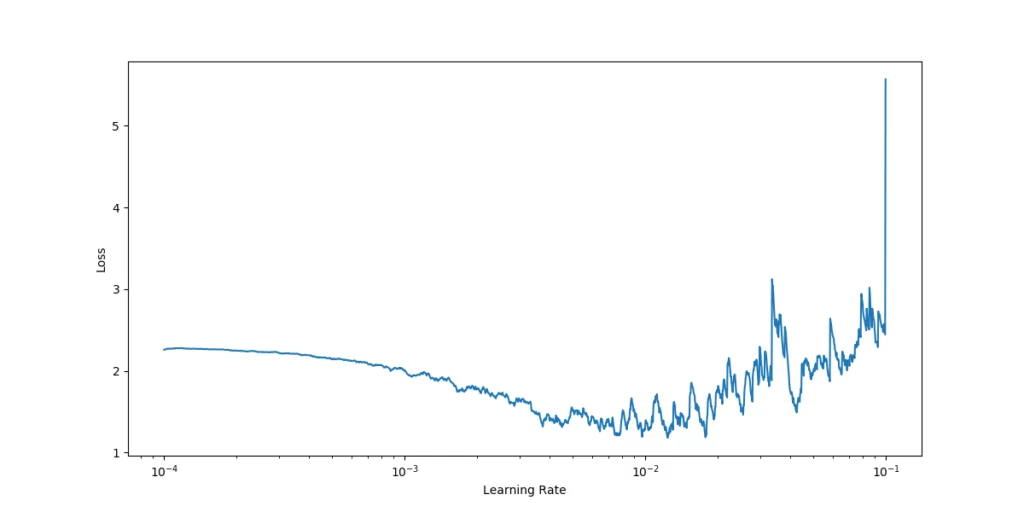

Interpreting this plot leads to the conclusion that a decrease in loss (i.e, model improvement) starts immediately – which means that we’ll choose 1e−4 as the lower bound for our Cyclical Learning Rate.

We observe a plateau around 1e−2, after which loss values become unstable. Hence, we choose this as the value for our upper bound, and set the bounds accordingly next.

In [ ]:
# en-US default

# Use Matplotlib inline
%matplotlib inline

lr_range_test = LearningRateRangeTest(min_lr = START_LR,
                                      max_lr = END_LR,
                                      language = 'en-US')


loaded_model.fit_generator(datagen.flow(x_train, y_train, batch_size = BATCH_SIZE),
                           epochs = N_EPOCHS,
                           verbose = 1,
                           validation_data = (x_val, y_val),
                           validation_steps = N_BATCHS_VAL, 
                           steps_per_epoch = N_BATCHS,
                           callbacks = [lr_range_test])

In [ ]:
# pt-BR

# Use Matplotlib inline
%matplotlib inline

lr_range_test = LearningRateRangeTest(min_lr = START_LR,
                                      max_lr = END_LR,
                                      language = 'pt-BR')


loaded_model.fit_generator(datagen.flow(x_train, y_train, batch_size = BATCH_SIZE),
                           epochs = N_EPOCHS,
                           verbose = 1,
                           validation_data = (x_val, y_val),
                           validation_steps = N_BATCHS_VAL, 
                           steps_per_epoch = N_BATCHS,
                           callbacks = [lr_range_test])

Now that we know which bounds we’ll use, we can applying Cyclical Learning Rates in the Keras model

# Credits

- [Training your Neural Network with Cyclical Learning Rates](https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/)

- [LRFinder](https://github.com/WittmannF/LRFinder) by Fernando Wittmann